# Data preparation

In [3]:
import torch

# Use GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import numpy as np

def get_user_rating_matrix(path='./user-rating_matrix.npy'):
	return np.load(path)

def get_recipe_feature_map(path='./Recipe-feature_map.npy'):
	return np.load(path).T

# Load the user-ratings and recipe-feature matrices
ur = get_user_rating_matrix()
rf = get_recipe_feature_map()

In [5]:
# Split data into train and test sets
def split_to_train_test(user_ratings, recipe_feature, test_percentage):
    total_columns = user_ratings.shape[1]
    test_column_count = round(test_percentage*total_columns)
    ur_train = user_ratings[:, :-test_column_count]
    ur_test = user_ratings[:, -test_column_count:]
    rf_train = recipe_feature[:-test_column_count, :]
    rf_test = recipe_feature[-test_column_count:, :]
    return ur_train, ur_test, rf_train, rf_test

ur_train, ur_test, rf_train, rf_test = split_to_train_test(ur, rf, .2)
ur_train, ur_val, rf_train, rf_val = split_to_train_test(ur_train, rf_train, .2)

In [6]:
from torch.utils.data import Dataset, DataLoader

# Create RatingDataset class to help with loading data
class RatingDataset(Dataset):
    def __init__(self, user_ratings):
        self.user_ratings = user_ratings
        self.row_indices, self.col_indices = user_ratings.nonzero()
	
    def __len__(self):
        return len(self.row_indices)
	
    def __getitem__(self, idx):
        row = self.row_indices[idx]
        col = self.col_indices[idx]
        rating = self.user_ratings[row, col]
        return torch.LongTensor([row]).to(device), \
            torch.LongTensor([col]).to(device), \
            torch.FloatTensor([rating]).to(device)

batch_size = 1000
train_loader = DataLoader(RatingDataset(ur_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(RatingDataset(ur_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(RatingDataset(ur_test), batch_size=batch_size, shuffle=True)

# Model

In [7]:
import torch.nn

class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=80):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [9]:
model = MatrixFactorization(1000, 40818).to(device)

# Training

In [12]:
import torch.optim as optim

# Use MSE as the loss function
criterion = torch.nn.MSELoss()

# Use SGD to optimize the weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
import copy

epochs = 20

best_model = None
best_mse = 1000
train_mse = []
val_mse = []

for epoch in range(epochs):
    train_loss_tot = 0.
    train_ctr = 0
    for row_batch, col_batch, rating_batch in train_loader:
        optimizer.zero_grad()
        
        # Predict rating and calculate loss
        prediction = model(row_batch.squeeze(), col_batch.squeeze())
        loss = criterion(prediction, rating_batch.squeeze())
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Update loss total
        train_loss_tot += loss.item()
        train_ctr += 1
    
    val_loss_tot = 0.
    val_ctr = 0
    with torch.no_grad():
        for row_batch, col_batch, rating_batch in val_loader:
            # Predict rating and calculate loss
            prediction = model(row_batch.squeeze(), col_batch.squeeze())
            loss = criterion(prediction, rating_batch.squeeze())
            
            # Update loss total
            val_loss_tot += loss.item()
            val_ctr += 1
        
    train_mse += [train_loss_tot / train_ctr]
    val_mse += [val_loss_tot / val_ctr]

    print('[epoch:{}] Train MSE: {}, Validation MSE: {}'.format(
        epoch,
        train_mse[-1],
        val_mse[-1]
    ))
    if val_mse[-1] < best_mse:
        best_mse = val_mse[-1]
        best_model = copy.deepcopy(model)

plt.plot(train_mse, label='train')
plt.plot(val_mse, label='validation')
plt.legend()
plt.show()
print('Finished training!')
print('Best validation loss: {}'.format(best_mse))
model = best_model
    

[epoch:0] Train MSE: 1.1779935757319133, Validation MSE: 4.028842613913796
[epoch:1] Train MSE: 0.907016555760421, Validation MSE: 3.340088545192372
[epoch:2] Train MSE: 0.7334541038555258, Validation MSE: 2.871681716225364
[epoch:3] Train MSE: 0.6060106567308015, Validation MSE: 2.5403490283272485
[epoch:4] Train MSE: 0.5074233830559487, Validation MSE: 2.3203364979137073
[epoch:5] Train MSE: 0.4288037154896587, Validation MSE: 2.171895712072199
[epoch:6] Train MSE: 0.36382949512963203, Validation MSE: 2.073736665465615
[epoch:7] Train MSE: 0.31034909071875555, Validation MSE: 2.0075341311368073
[epoch:8] Train MSE: 0.26631374657154083, Validation MSE: 1.9695789575576783
[epoch:9] Train MSE: 0.22914464260433234, Validation MSE: 1.9497380711815573
[epoch:10] Train MSE: 0.1986958534986365, Validation MSE: 1.9452612313357267
[epoch:11] Train MSE: 0.17335258650721289, Validation MSE: 1.9419022083282471
[epoch:12] Train MSE: 0.1522410259965588, Validation MSE: 1.9479997960003939
[epoch:13]

NameError: ignored

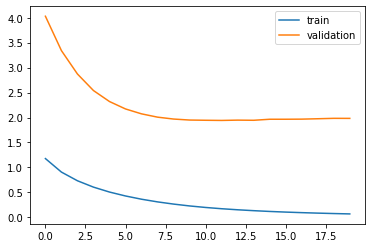

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_mse, label='train')
plt.plot(val_mse, label='validation')
plt.legend()
plt.show()

In [17]:
from math import sqrt

test_loss_tot = 0.
test_ctr = 0
with torch.no_grad():
    for row_batch, col_batch, rating_batch in test_loader:
        # Predict rating and calculate loss
        prediction = model(row_batch.squeeze(), col_batch.squeeze())
        loss = criterion(prediction, rating_batch.squeeze())
        
        # Update loss total
        test_loss_tot += loss.item()
        test_ctr += 1

test_rmse = sqrt(test_loss_tot / test_ctr)
print('Test RMSE: %.5f' % test_rmse)

Test RMSE: 1.41586
